In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import os
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
import cftime

In [2]:
ds = xr.open_dataset('/glade/work/dmeidan/WACCM_forcast_files/Daphne-emission_x3/emissions-fcst_bc_a4_bb_surface_0.9x1.25.nc')

In [3]:
ds2 = ds.sel(time=slice('2023-01-01', '2023-12-01'))
ds2.time

<xarray.DataArray 'time' (time: 335)>
array(['2023-01-01T00:00:00.000000000', '2023-01-02T00:00:00.000000000',
       '2023-01-03T00:00:00.000000000', ..., '2023-11-29T00:00:00.000000000',
       '2023-11-30T00:00:00.000000000', '2023-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-12-01
Attributes:
    long_name:  Time

In [4]:
ds3 = xr.open_dataset("/glade/p/cesmdata/cseg/inputdata/atm/cam/chem/emis/CMIP6_emissions_2010climo/emissions-cmip6_bc_a4_bb_surface_2010climo_0.9x1.25_c20170322.nc")
ds3.time

<xarray.DataArray 'time' (time: 12)>
array(['2010-01-15T21:45:00.000000000', '2010-02-15T21:45:00.000000000',
       '2010-03-16T02:15:00.000000000', '2010-04-16T02:15:00.000000000',
       '2010-05-16T02:15:00.000000000', '2010-06-16T02:15:00.000000000',
       '2010-07-16T02:15:00.000000000', '2010-08-16T02:15:00.000000000',
       '2010-09-16T02:15:00.000000000', '2010-10-16T02:15:00.000000000',
       '2010-11-16T02:15:00.000000000', '2010-12-16T02:15:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2010-01-15T21:45:00 ... 2010-12-16T02:15:00
Attributes:
    long_name:     Time
    cell_methods:  time: mean

In [5]:
dst = xr.open_dataset("/glade/work/jinmuluo/CanadianFire2023/EmissionInventory/emissions-fcst_XYLENES_bb_surface_0.9x1.25.nc")
dst.time

<xarray.DataArray 'time' (time: 12)>
array(['2010-01-15T21:45:00.000000000', '2010-02-15T21:45:00.000000000',
       '2010-03-16T02:15:00.000000000', '2010-04-16T02:15:00.000000000',
       '2010-05-16T02:15:00.000000000', '2010-06-16T02:15:00.000000000',
       '2010-07-16T02:15:00.000000000', '2010-08-16T02:15:00.000000000',
       '2010-09-16T02:15:00.000000000', '2010-10-16T02:15:00.000000000',
       '2010-11-16T02:15:00.000000000', '2010-12-16T02:15:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2010-01-15T21:45:00 ... 2010-12-16T02:15:00
Attributes:
    long_name:     Time
    cell_methods:  time: mean

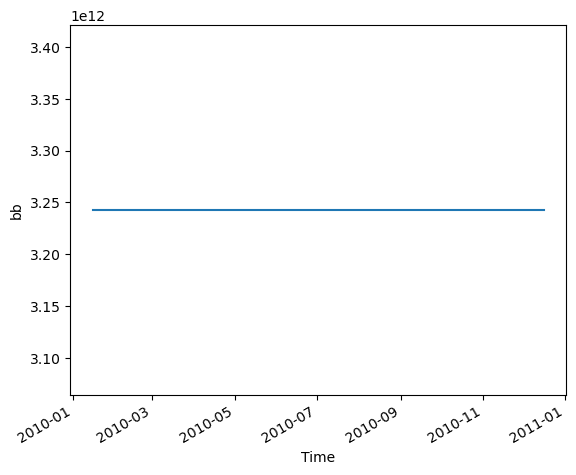

In [6]:
dst.bb.sum(dim=['lat', 'lon']).plot()